# 16ML Week 6: Hierarchical Clustering

In this assignment, we will explore the theory and application of *hierarchical clustering*, a clustering algorithm that splits or joins clusters based on a flexible cluster similarlity metric until a stopping condition is satisfied.

## Algorithm Overview

Hierarchical clustering creates a tree-like structure that allows you to assign a data point to a cluster. The tree can be created from the bottom up, or from the top down. Each of these methods corresponds to a variant of hierarchical clustering; aptly named *agglomerative* and *divisive* clustering, respectively. When using the bottom-up approach, the algorithm starts with each data point in its own cluster, and successively merges the closest two clusters into one cluster until it has reached the desired number of clusters. The top-down approach does the reverse: it splits each cluster into two until the cluster can no longer be divided.

In the remainder of this problem set, we will
1. observe a demo of hierarchical clustering
2. implement each variant of hirarchical clustering, and compare the two
3. develop an intution for setting hyperparameters using sklearn's [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) or scipy's [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) function.
4. apply hierarchical clustering on real world problem settings

# Part 1: Demo

In this section, we'll look at some example datasets and how K-Means and hierarchical clustering perform to gain an intution for the strengths and weaknesses of each algorithm.

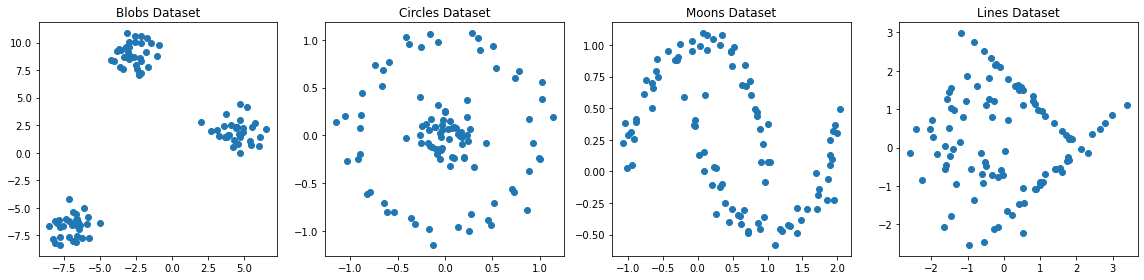

In [ ]:
#@title Sample datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles, make_classification, make_moons

COLORS = np.array(sns.color_palette())

class Dataset:
  def __init__(self, data, title, n_clusters):
    self.data = data
    self.data.flags.writeable = False
    self.title = title
    self.n_clusters = n_clusters

  @property
  def x(self):
    return self.data[:, 0]

  @property
  def y(self):
    return self.data[:, 1]

  def plot(self, axis, coloraxis=None):
    axis.scatter(self.x, self.y, c=coloraxis)
    axis.set_title(f'{self.title} Dataset')

  def plot_clusters(self, clusterer, axis):
    pred_clusters = clusterer.fit_predict(self.data)
    self.plot(axis, coloraxis=COLORS[pred_clusters])
    

blobs_dataset = Dataset(make_blobs(centers=3, random_state=42)[0], 'Blobs', 3)
circles_dataset = Dataset(make_circles(noise=0.09, factor=.2, random_state=42)[0], 'Circles', 2)
lines_dataset = Dataset(make_classification(n_features=2, n_redundant=0, random_state=4242)[0], 'Lines', 3)
moons_dataset = Dataset(make_moons(noise=0.07)[0], 'Moons', 2)

datasets = [
  blobs_dataset,
  circles_dataset,
  moons_dataset,
  lines_dataset,
]

def plt_datasets(datasets, title=None, plotter=Dataset.plot):
  fig, axes = plt.subplots(nrows=1,
                           ncols=len(datasets),
                           figsize=(4*len(datasets), 4))
  for (dataset, axis) in zip(datasets, axes):
    plotter(dataset, axis)
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()

plt_datasets(datasets)

## K-Means

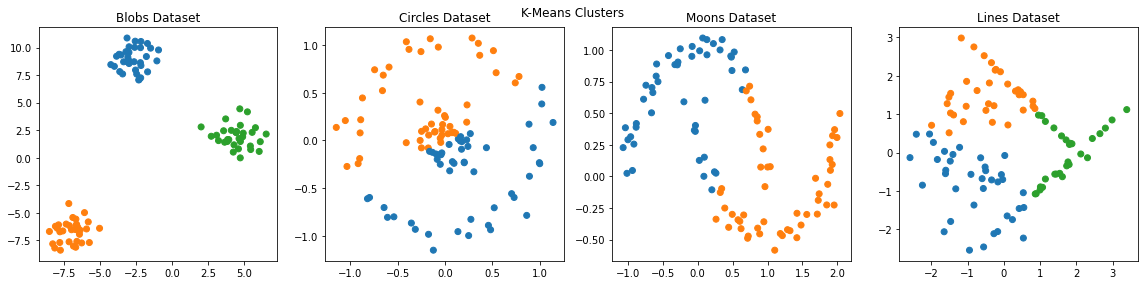

In [ ]:
#@title K-Means Clusters
from sklearn.cluster import KMeans
plt_datasets(datasets,
             title='K-Means Clusters',
             plotter=lambda dataset, axis: dataset.plot_clusters(
                 KMeans(n_clusters=dataset.n_clusters), axis))

As we may expect, K-Means works well when its assumptions are followed.The clusters are well separated blobs in Euclidean space. However, that only applies to the first dataset.

For the second _Circles_ dataset, you could consider using the kernel K-Means algorithm that you designed on the previous homework, but the _Moons_ and _Lines_ datasets would require challening kernel functions. What if we could use a different algorithm entirely? How about heirarchical clustering?

## Hierarchical Clustering

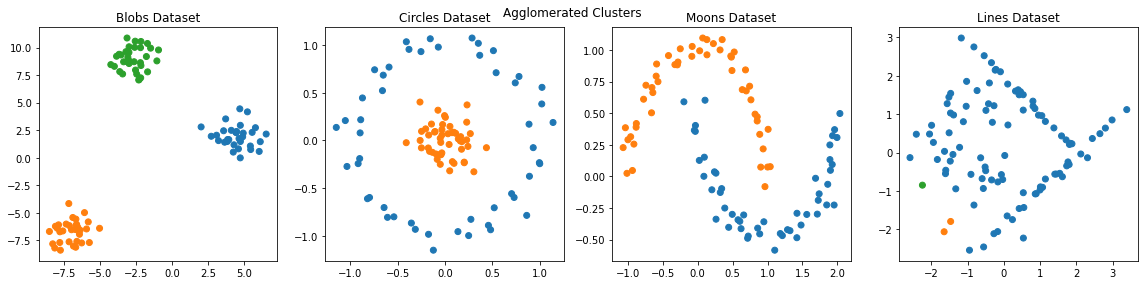

In [ ]:
#@title Heirarchical Clustering Clusters
from sklearn.cluster import AgglomerativeClustering
plt_datasets(datasets,
             title='Agglomerated Clusters',
             plotter=lambda dataset, axis: dataset.plot_clusters(
                 AgglomerativeClustering(linkage='single', n_clusters=dataset.n_clusters),
                 axis))

Ah, much better. The second and third datasets' clustering results are looking pretty good! The fourth one, not so much, but we'll work on that one later.

Let's focus in on the details of the second plot to gain an intiution for the algorithm. It'll come in handy when you implement hierarchical clustering in the following sections.

Recall that agglomerative clustering successively merges the two "nearest" clusters until the desired number of clusters remain. The following cell plots the algorithm's progress as five clusters are merged into the final two, as well as the resulting *dendrogram*.

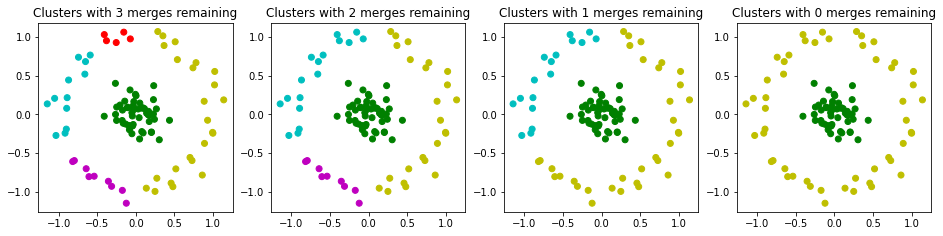

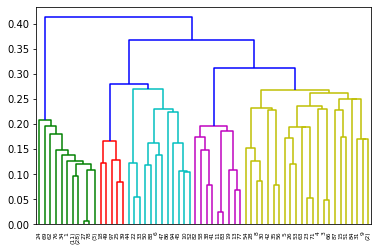

In [ ]:
#@title Agglomerative clusters
import numpy as np
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

def calc_linkage_matrix(clusterer):
    counts = np.zeros(clusterer.children_.shape[0])
    n_samples = len(clusterer.labels_)
    for i, merge in enumerate(clusterer.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [clusterer.children_,  clusterer.distances_, counts]).astype(float)

clusterer = AgglomerativeClustering(distance_threshold=0.4, n_clusters=None, linkage='single')
clusterer.fit(circles_dataset.data)

linkage = calc_linkage_matrix(clusterer)

trees = hierarchy.cut_tree(linkage, n_clusters=list(range(5, 1, -1)))

nrows = 1
ncols = trees.shape[1] // nrows
fig, axes = plt.subplots(nrows=1,
                         ncols=trees.shape[1],
                         figsize=(4*trees.shape[1], 4))

DENDROGRAM_COLORS = np.array(['g', 'y', 'c', 'm', 'r'])
            
for i in range(trees.shape[1]):
  ax = axes[i]
  ax.set_aspect('equal')
  ax.scatter(circles_dataset.x, circles_dataset.y, c=DENDROGRAM_COLORS[trees[:, i]])
  ax.set_title(f'Clusters with {trees.shape[1] - i - 1} merges remaining')
plt.show()

hierarchy.dendrogram(linkage, truncate_mode='level', p=8, color_threshold=.28);

We see that the central circle is well classified early on: even with 3 merges remaining, the subtree in the dendrogram (green) requires no further merges. However, the outer circle, due to noise and sparsity has three extra clusters.

The first of the outer ring's clusters to be merged are red and cyan, which happens because they are the two clusters with points closest together (for some definition of _close_, which we will explore later). Next, yellow and magenta are merged, as we see as the third highest node in the dendrogram. Finally, the (merged) cyan and (merged) yellow clusters are merged, leaving us with the two clusters that we so greatly desire.

# Part 2: Implement Hierarchical Clustering

In this section, you will have the chance to implement both agglomerative and divisive clustering with the given interface. After finishing the implementation, you can verify the correctness of your implementation via the interative demo and compare the result with sklearn implementation. 

In [ ]:
# we first import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from typing import Dict, Set

For simplicity, we assume the given data is of 2 dimensional. We provide the following interface to you. Fill in the blanks. 

In [ ]:
class Cluster:
    '''
	Class which defines a single cluster
	'''
    def __init__(self, cluster_id: int, data_indexes: Set[int]):
        '''
        Initialize the cluster with unique cluster id and corresponding data currently contained in the cluster
        '''
        self.id = cluster_id
        self.data_indexes = data_indexes
        self.min = (-1, np.inf)  # (id, dissimilarity)
    
    def merge(self, c: "Cluster"):
        '''
        Merges the data indexes in "c" into the current cluster
        '''
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###

    def __len__(self):
        return len(self.data_indexes)


class Clustering:
    '''
	Class inherited by different hierarchical clustering methods
	'''
    def __init__(self, data: np.ndarray):
        '''
        Initialize with all data points and linkage function
        '''
        self.n_clusters = 0
        self.data = data
        self.n_data = data.shape[0]
        self.clusters: Dict[int, Cluster] = {}  # id: cluster
        self.dissimilarity_table = np.zeros((self.n_data, self.n_data))

    def add_cluster(self, cluster: Cluster):
        '''
        Add a new cluster object
        '''
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###

    def remove_cluster(self, cluster_id: int):
        '''
        Remove a merged cluster
        '''
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###


Implement affinity function and four different types of linkage function below.

In [ ]:
def affinity(x, y):
    '''
    Return the Eclidian distance between two data points x and y (here we assume they are both 2D vector)
    '''
    ### Implementation Starts ###
    pass
    ### Implementation Ends ###


def single_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the single linkage dissimilarity
    '''
    ### Implementation Starts ###
    pass
    ### Implementation Ends ###


def complete_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the complete linkage dissimilarity
    '''
    ### Implementation Starts ###
    pass
    ### Implementation Ends ###


def average_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the average linkage dissimilarity
    '''
    ### Implementation Starts ###
    pass
    ### Implementation Ends ###


def ward_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the ward linkage dissimilarity
    '''
    ### Implementation Starts ###
    pass
    ### Implementation Ends ###


## Impelmentation of Agglomerative Clustering

In [ ]:
class AggClustering(Clustering):
    def __init__(self, data, linkage_func):
        super().__init__(data)
        '''
        Initialize agglomerative clustering with n separate clusters and initialize the dissimilarity_table and nearest neighbour of each cluster
        '''
        self.linkage = linkage_func
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###

    def find_minimum_pair(self):
        '''
        Find the pair of cluster with minimum dissimilarity
        ----
        Return: index of two clusters
        '''
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###

    def merge_update_cluster(self, target_id: int, victim_id: int):
        '''
        This function need to deal with three tasks
            1. Merge the cluster with id victim_id into the cluster with id target_id
            2. Update the dissimilarity with respect to victim cluster
            3. Update the closest neighbour
        '''
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###


In [ ]:
# code for interactive demo; no implementation needed
def plot_clustering(dataset, assignments):
    for i, indexes in assignments.items():
        plt.scatter(dataset[list(indexes), 0], dataset[list(indexes), 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


def interact_clustering(dataset, logger):
    history = list(logger)

    def plotter(i):
        plot_clustering(dataset, history[i])

    interact(plotter, i=IntSlider(min=0, max=len(history) - 1, continuous_update=False))


In [ ]:
def copy_cluster_assignments(clusters):
    assignments = {}
    for i, cluster in clusters.items():
        assignments[i] = cluster.data_indexes.copy()
    return assignments

def perform_agglomerative_clustering(n_cluster, dataset, linkage_func):
    clusters = AggClustering(dataset, linkage_func)
    while clusters.n_clusters > n_cluster:
        yield copy_cluster_assignments(clusters.clusters)
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###
    yield copy_cluster_assignments(clusters.clusters)

def final_agglomerative_clustering(n_cluster, dataset, linkage_func):
    out = list(perform_agglomerative_clustering(n_cluster, dataset, linkage_func))
    return out[-1]

After implementing all the functions above, we can enjoy the following interactive plot. Adjust *num* and *linkage_func* and compare different linkage functions.

In [ ]:
num = 10
dataset = np.random.rand(num, 2)
interact_clustering(dataset, perform_agglomerative_clustering(1, dataset, single_linkage))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=9), Output()), _dom_cla…

If you find your implementation work correctly on the above toy examples, you can validate the implementation on larger cases by comparing with Sklearn's Agglomerative Clustering function below. Feel free to try out different number of clusters, linkage functions, etc.

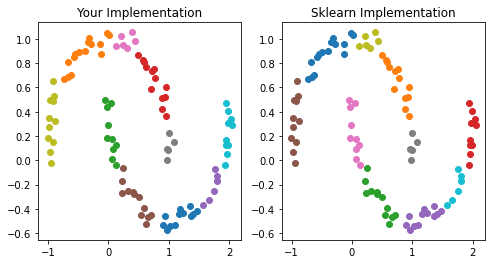

In [ ]:
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering
# generate dataset
moons_dataset = Dataset(make_moons(noise=0.05)[0], 'Moons', 2)
dataset = np.vstack((moons_dataset.x, moons_dataset.y)).T

linkage_mapping = {'ward': ward_linkage, 'single': single_linkage, 'complete': complete_linkage, 'average': average_linkage}

def plot_and_compare(n_clusters, dataset, linkage="ward"):
    result = final_agglomerative_clustering(n_clusters, dataset, linkage_mapping[linkage])
    labels = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage).fit(dataset)

    def visualize_clusters(axis, data, labels, title):
        cluster_labels = set(labels)
        for i in cluster_labels:
            axis.scatter(data[labels == i][:, 0], data[labels == i][:, 1])
        axis.set(title=title)
    
    def plot_clustering(axis, dataset, assignments, title):
        for i, indexes in assignments.items():
            axis.scatter(dataset[list(indexes), 0], dataset[list(indexes), 1])
        axis.set(title=title)
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plot_clustering(ax1, dataset, result, "Your Implementation")
    visualize_clusters(ax2, dataset, labels.labels_, "Sklearn Implementation")
    fig.show()

plot_and_compare(n_clusters=10, dataset=dataset, linkage="average")

Congratulations, you have successfully finished this part.

## Impelmentation of Divisive Clustering

After finishing the agglomerative clustering, it is also a good practice to implement the divisive clustering. Divisive clustering is a more challenging task compared to the agglomerative one, so we will provide more information in the provided interface.

In [ ]:
class DivisiveClustering(Clustering):
    def __init__(self, data):
        '''
        Initialize divisive clustering with 1 entire clusters and dissimilarity_table
        '''
        super().__init__(data)
        self.last_index = 2 * self.n_data
        self.add_cluster(Cluster(self.last_index, set(range(self.n_data))))
        temp_clusters = {}
        for i in range(self.n_data):
            temp_clusters[i] = Cluster(i, {i})
        for i in range(self.n_data):
            for j in range(self.n_data):
                distance = affinity(self.data[i], self.data[j])
                self.dissimilarity_table[i, j] = distance
        for i in range(self.n_data):
            self.dissimilarity_table[i, i] = 0

    def splinter(self):
        '''
        1. Find the cluster with largest diameter
        2. Find the splinter element (point inside the cluster with maximum average distance w.r.t others)
        ---
        Return: splinter element, max diameter cluster's id
        '''
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###

    def reassign(self, splinter_element, orig_cluster_key):
        '''
        1. Judge whether other data points inside the target cluster belongs to splinter group
        2. Split the cluster
        '''
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###



In [ ]:
def perform_divisive_clustering(n_cluster, dataset):
    clustering = DivisiveClustering(dataset)
    while clustering.n_clusters < n_cluster:
        yield copy_cluster_assignments(clustering.clusters)
        ### Implementation Starts ###
        pass
        ### Implementation Ends ###
    yield copy_cluster_assignments(clustering.clusters)

def final_agglomerative_clustering(n_cluster, dataset):
    out = list(perform_divisive_clustering(n_cluster, dataset))
    return out[-1]

In [ ]:
num = 10
dataset = np.random.rand(num, 2)
interact_clustering(dataset, perform_divisive_clustering(8, dataset))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=7), Output()), _dom_cla…

# Part 3: Explore Agglomerative Clustering Hyperparameters

Now you have obtained a better understanding of how agglomerative and divisive clustering works, and you can also see that the time complexity of hierarchical clustering algorithms are quite high. In practical settings, you seldom need to implement the algorithm from scratch. Even when you do that, you will be able to realize a more efficient version of the algorithm with priority queue (a useful data structure that you will soon encounter in the following weeks of CS61B).   
In practical cases, you will use Sklearn [Agglomerative Clustering function](https://sklearn.cluster.AgglomerativeClustering) or scipy [linkage function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). They can both perform agglomerative clustering, but each of them has its own advantage over the other.  Sklearn's AgglomerativeClustering is more convenient to directly visualize final clustering results, while scipy's linkage function is better at demostrating the dendrogram (the linkage process).  
In this sections, we will take advantage of sklearn's AgglomerativeClustering to demo various possibilities of setting hyperparameters.

## Tuning linkage function

In practical setting, when you wish to apply agglomerative clustering, you need to pick the most approperiate clustering function. As for Sklearn Agglomerative Clustering, choices are single linkage, complete linkage, average linkage, and ward linkage. Different linkage function will be useful for different types/shapes of clusters. For the toy examples, you need to decide for the most apprioriate linkage function, visualize the result, and explain your choice and the underlying reason.  

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
def visualize_clusters(data, labels):
    cluster_labels = set(labels)
    for i in cluster_labels:
        plt.scatter(data[labels == i][:, 0], data[labels == i][:, 1])
    plt.gca().set_aspect('equal', adjustable='box')

Case 1:

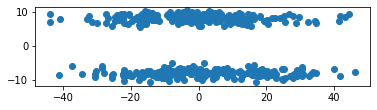

In [ ]:
np.random.seed(101)
classA = np.random.randn(200, 2) * np.array([[16, 1]]) + np.array([[0, 8]])
classB = np.random.randn(200, 2) * np.array([[16, 1]]) + np.array([[0, -8]])
data = np.concatenate((classA, classB), axis = 0)
plt.scatter(data[:,0], data[:,1])
plt.gca().set_aspect('equal', adjustable='box')

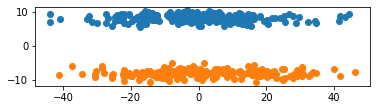

In [ ]:
# Fill in your choice
result = AgglomerativeClustering(n_clusters = pass, linkage = pass).fit(data)
visualize_clusters(data, result.labels_)

Explanation Starts Here

Case 2:

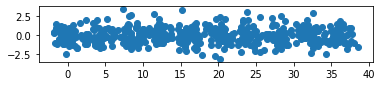

In [ ]:
np.random.seed(100)
data = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), 50)
for i in range(1, 10):
    new_group = np.random.multivariate_normal(np.array([4 * i, 0]), np.array([[1, 0], [0, 1]]), 50)
    data = np.concatenate((data, new_group), axis = 0)
plt.scatter(data[:,0], data[:,1])
plt.gca().set_aspect('equal', adjustable='box');

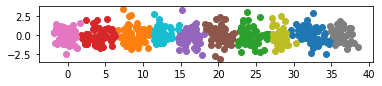

In [ ]:
# Fill in your choice
result = AgglomerativeClustering(n_clusters = pass, linkage = pass).fit(data)
visualize_clusters(data, result.labels_)

Explanation Starts Here 


Case 3:

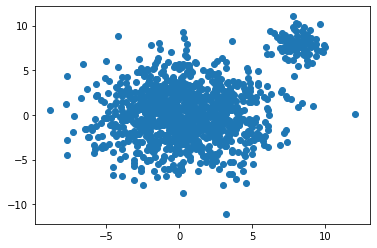

In [ ]:
np.random.seed(101)
group1 = np.random.multivariate_normal(np.array([0, 0]), np.array([[8, 0], [0, 8]]), 1000)
group2 = np.random.multivariate_normal(np.array([8, 8]), np.array([[1, 0], [0, 1]]), 100)
data = np.concatenate((group1, group2), axis = 0)
plt.scatter(data[:,0], data[:,1]);

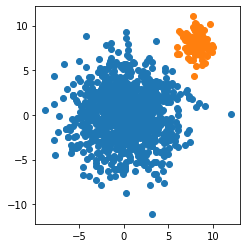

In [ ]:
# Fill in your choice
result = AgglomerativeClustering(n_clusters = pass, linkage = pass).fit(data)
visualize_clusters(data, result.labels_)

Explanation Starts Here 

## Choose Appropriate Affinity Function



In many cases, the default Euclidean distance function is no longer appropriate in depicting the dissimilarity between two data points. For the following case, image that we wish to cluster the fan-shaped dataset into sectors. Explore different affinity metric to achieve the desired result. 

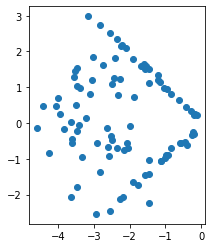

In [ ]:
from sklearn.datasets import make_classification
lines_dataset = Dataset(make_classification(n_features=2, n_redundant=0, random_state=4242)[0], 'Lines', 3)
dataset = np.vstack((lines_dataset.x, lines_dataset.y)).T
dataset = dataset[dataset[:,0]<2] + [-2, 0]
plt.scatter(dataset[:,0], dataset[:,1])
plt.gca().set_aspect('equal', adjustable='box');

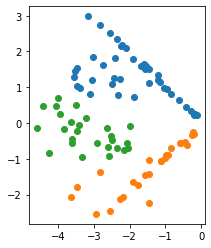

In [ ]:
### Start your answer here ###
result = AgglomerativeClustering(n_clusters = pass, linkage = pass, affinity=pass).fit(dataset)
visualize_clusters(dataset, result.labels_)

# Part 4: Practical Application

Finally, you will have the chance to apply clustering in some more practical settings.

## How Many Beacons? 

We start with a setting that you are already familiar with in ee16a lectures and labs. In APS lab, you are required to determine the distance between your receiver and different beacons. Now we change the setting by a little bit. You have collected a bunch of equal length signals, transmitted from an unknown number of beacons. Although you have no idea how each beacon signal looks like, you know that they are different and each received signal only contains one beacon pattern rather than contain an interleaving of multiple beacon patterns. Received signal from a beacon may be delayed by different timestamps and corrupted with noise.  
Load the `signals.pkl` dataset, ignore the `beacon` column which contains the correct labels, cluster the unlabelled signals using agglomerative clustering, and report the clustering result as well as number of different beacons.   
Guidelines:
You can follow the given steps to finish this problem.
- Load the dataset
- Apply Agglomerative Clustering with correct affinity function with scipy linkage function. (since signal vectors are all with high dimension, please wait for a few minutes for it to complete)
- Draw dendrogram to determine the number of clusters

In [1]:
### Start Your Code Below ###


## Cluster Analysis of Bike Sharing System

In this part, you will deal with real-life setting. You are given the citi-bike trip dataset, and we hope that you can perform some open-ended clustering analysis for bike stations according to trip patterns.   
The restrictions are:
- The objects for clustering are bike stations
- The analysis process/clustering criteria must involve user behavior or trip patterns. Simply use geographical distance to cluster stations is forbiddened
- You need to do some visualization to confirm your result (e.g. use folium map)

State the objective for you analysis here.  
Objective Starts Here  


In [ ]:
### Start Your Code Below ###


Congratulations! You have finished this homework. Now you are familiar with hierarchical clustering and the corresponding applications. You will get to know more clustering algorithm in other topics of this week. 

# References:

Bikesharing dataset: https://www.kaggle.com/andytran11996/citibike-dataset-2017?select=201701-citibike-tripdata.csv  